In [1]:
import os, simplejson
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cluster_model import ClusterModel
from state_optimization import StateOptimization
from datetime import timedelta
import parameter
import pickle
import seaborn as sns
import integer_programming as ip

In [2]:
with open('../data/station_data/2024 model/v2/tph_4/data.pickle', 'rb') as f:
    station_data = pickle.load(f)
    
with open('../station_information.json', 'r') as f:
    station_information = simplejson.load(f)['data']['stations']

# path = '../data/station_data/status_at_time/2024_6_20_2:19.csv'
# time = timedelta(hours=6)
# length = timedelta(hours=2)
tph = 4
square_size = 0.005

In [3]:
model = ClusterModel(station_data=station_data, in_transit=[], tph=tph)
model.init_clusters(square_length=square_size)

model_2 = ClusterModel(station_data=station_data, in_transit=[], tph=4)
model_2.init_clusters(square_length=square_size)

start_df = parameter.get_state_df(station_information, f'rebalancing/data/9/2024-07-09-10-00.pickle')
end_df = parameter.get_state_df(station_information, f'rebalancing/data/9/2024-07-09-14-00.pickle')
model.init_df_state(start_df, time=timedelta(hours=6))
model_2.init_df_state(end_df, time=timedelta(hours=10))
# model.init_state(path=path, time=time)

original_state = {i: model.cluster_dict[i].curr_bikes for i in model.cluster_dict}
end_state = {i: model_2.cluster_dict[i].curr_bikes for i in model_2.cluster_dict}
original_clusters = {cluster.name: cluster for cluster in model.cluster_dict.values()}

state_optimization = StateOptimization(model)
# opt_state = state_optimization.optimize(length=length)

# model.show_bikes()

# num_stations = [len(cluster) for cluster in clusters]
# sns.heatmap(np.array(num_stations).reshape((vertical_squares, horizontal_squares)))

36 horizontal squares and 51 vertical squares. Total squares: 1836
36 horizontal squares and 51 vertical squares. Total squares: 1836


In [4]:
for cluster in model.cluster_dict.values():
    cluster.rate = [rate*1.75 for rate in cluster.rate]
# model.init_by_3()


In [123]:
print('Initial MSE to end state', model.mean_sq_error(model.cluster_dict, end_state))
print('MSE from origin state:', model.mean_sq_error(model.cluster_dict, original_state))
print('Total trips:', model.total_trips)
origin_mse = []
end_mse = []
total_trips = []
time = []

while model.curr_time < timedelta(hours=10):
    model.sim_by_3()
    # model.sim()
    # print('Current time:', model.curr_time)
    time.append(model.curr_time)
    # print('Total trips:', model.total_trips)
    total_trips.append(model.total_trips)
    # print('MSE from origin state:', model.mean_sq_error(model.cluster_dict, original_state))
    origin_mse.append(model.mean_sq_error(model.cluster_dict, original_state))
    # print('model MSE to end state:', model.mean_sq_error(model.cluster_dict, end_state))
    end_mse.append(model.mean_sq_error(model.cluster_dict, end_state))
    
print('MSE from origin state:', model.mean_sq_error(model.cluster_dict, original_state))
print('Model MSE to end state', model.mean_sq_error(model.cluster_dict, end_state))
print('Total trips:', model.total_trips)

Initial MSE to end state 1491.7390791027156
MSE from origin state: 0.0
Total trips: 0
Initial MSE to end state 189.71782762691853
MSE from origin state: 1411.891381345927
Total trips: 33292


<Figure size 1000x600 with 0 Axes>

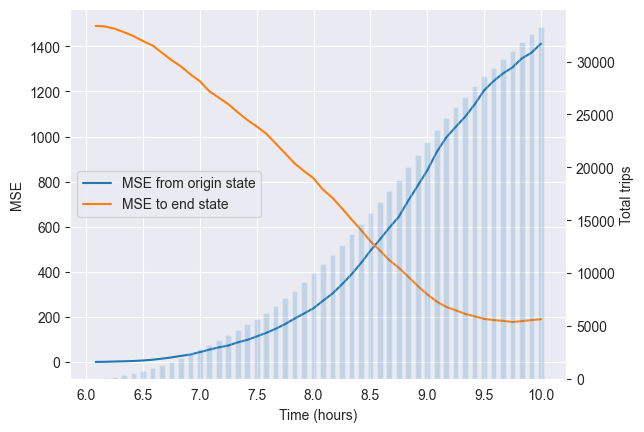

In [166]:
plt.figure(figsize=(10,6))
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot([stamp.total_seconds()/3600 for stamp in time], origin_mse, label='MSE from origin state')
ax1.plot([stamp.total_seconds()/3600 for stamp in time], end_mse, label='MSE to end state')
ax2.bar([stamp.total_seconds()/3600 for stamp in time], total_trips, alpha=0.2, label='Total trips', width=0.05)
ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('MSE')
ax1.legend(loc='center left')
ax2.set_ylabel('Total trips')
ax2.grid(False)
plt.show()

In [ ]:
model.sim()
model.sim()
model.reset_state(bike_state=original_state,in_transit=model.in_transit, time=timedelta(hours=6))

In [145]:
np.array([len(stations) for stations in model.clusters if len(stations)>0]).mean()

2.5194805194805197

Text(0.5, 1.0, 'Number of stations')

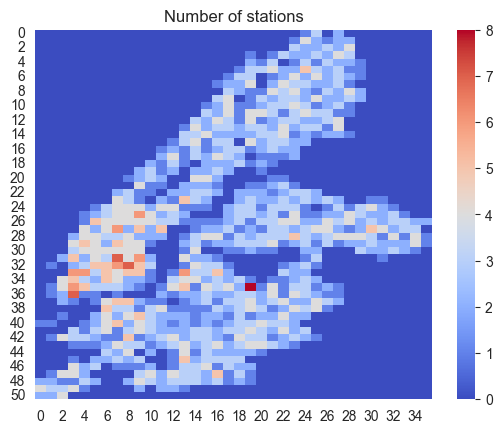

In [169]:
sns.heatmap(np.array([len(cluster) for cluster in model.clusters]).reshape(model.vertical_squares, model.horizontal_squares), cmap='coolwarm')
plt.title('Number of stations')

Text(0.5, 1.0, 'Max docks')

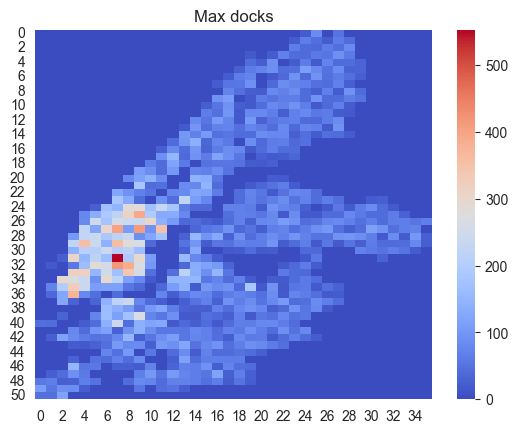

In [167]:
sns.heatmap(np.array([model.cluster_dict[cluster].max_docks if cluster in model.cluster_dict else 0 for cluster in range(len(model.clusters))]).reshape(model.vertical_squares, model.horizontal_squares), cmap='coolwarm')
plt.title('Max docks')

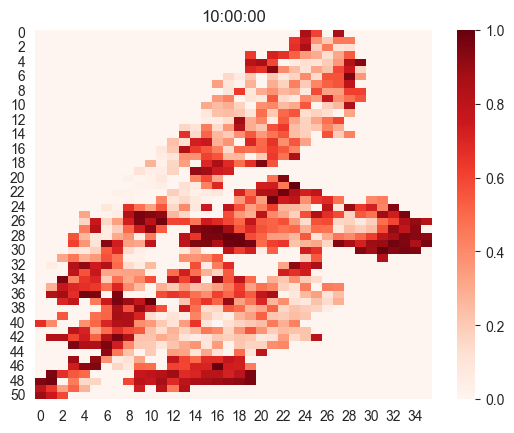

In [8]:
day = 9
files = os.listdir(f'rebalancing/data/{day}')
files.sort()
for i, file in enumerate(files[::3]):
    df = parameter.get_state_df(station_information, f'rebalancing/data/{day}/' + file,)
    split_file = file[:-7].split('-')
    hour = int(split_file[3])-4
    minute = int(split_file[4])
    if not 6 <= hour <= 10:
        continue
    if hour == 10 and minute != 0:
        continue
    model_2.init_df_state(df, time=timedelta(hours=(hour+minute/60)))
    if i < 10:
        i = f'00{i}'
    elif i < 100:
        i = f'0{i}'
    else:
        i = f'{i}'
    model_2.show_fill_percent(save=True, name=i, folder='images/fill_2/')

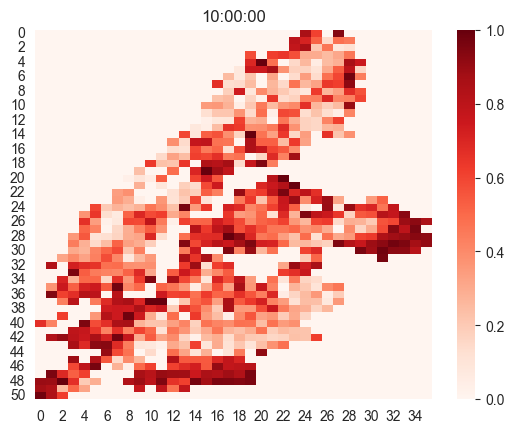

In [9]:
i = 0
while model.curr_time <= timedelta(hours=10):
    if i < 10:
        name = f'00{i}'
    elif i < 100:
        name = f'0{i}'
    else:
        name = f'{i}'
    model.show_fill_percent(save=True, name=name)
    i += 1
    model.sim()

In [10]:
os.system(f'magick images/fill/*.png fill_sim_9th_6-10.gif')
os.system(f'magick images/fill_2/*.png fill_real_9th_6-10.gif')
os.system('mv fill_sim_9th_6-10.gif gifs/1.gif')
os.system('mv fill_real_9th_6-10.gif gifs/2.gif')

os.system('cd gifs')
os.system('convert 1.gif -coalesce a-%04d.gif')     				# split frames of 1.gif into a-0001.gif, a-0002.gif etc
os.system('convert 2.gif -coalesce b-%04d.gif ')    				# split frames of 2.gif into b-0001.gif, b-0002.gif etc
os.system('for f in a-*.gif; do convert $f ${f/a/b} +append $f; done') 	# append frames side-by-side
os.system('convert -loop 0 -delay 20 a-*.gif result.gif')           

0

In [4]:
# with open('../data/ideal_states/2:19_14h_8steps_0.01sq.pickle', 'rb') as f:
#     opt_state = pickle.load(f)
#     
opt_state = state_optimization.optimize(length=timedelta(hours=4), steps=8)

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 22.5.0 22F66)

CPU model: Intel(R) Core(TM) i9-9980HK CPU @ 2.40GHz
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 138057 rows, 76555 columns and 603654 nonzeros
Model fingerprint: 0xc1731d8f
Variable types: 0 continuous, 76555 integer (38000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+02]
Presolve removed 22248 rows and 18014 columns
Presolve time: 2.10s
Presolved: 115809 rows, 58541 columns, 515231 nonzeros
Variable types: 0 continuous, 58541 integer (37908 binary)
Found heuristic solution: objective 357.0000000

Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...


Interrupt request received
Root barrier log...

Ordering time: 4.27s

Barrier statistics:
 AA' NZ     : 1.649e+06
 Factor NZ

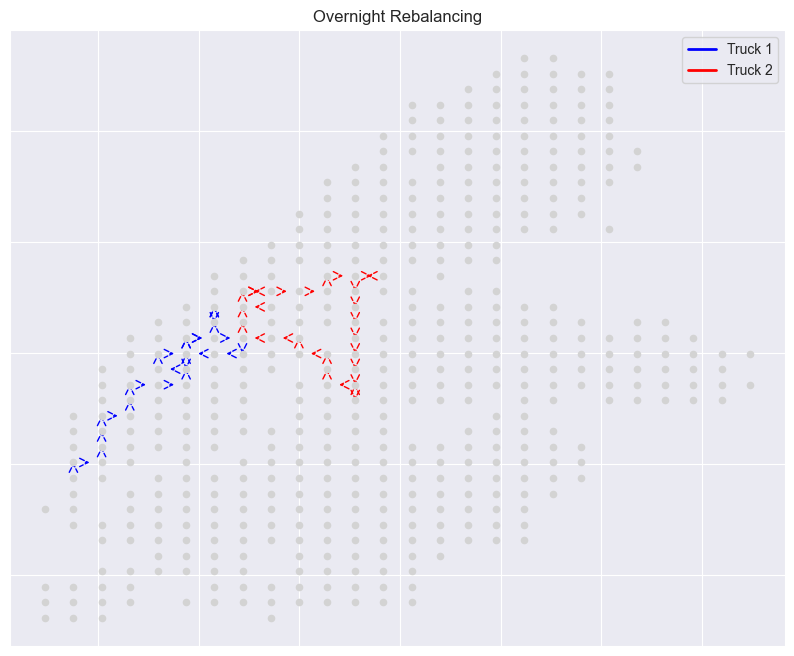

In [6]:
start_levels = {cluster.name: cluster.curr_bikes for cluster in model.cluster_dict.values()}
positions = {cluster.name: (cluster.lon, cluster.lat) for cluster in model.cluster_dict.values()}
adjacency = model.get_adjacent_clusters()
clusters = [cluster for cluster in model.cluster_dict.keys()]
# opt_state = {cluster.name: 2 for cluster in model.cluster_dict.values()}

T = 40
K = 2
L = 30


ip_model, x, y, b = ip.create_model(T=T, K=K, L=L, 
                start_levels=start_levels,
                stations=clusters, 
                optimal_levels=opt_state, 
                positions=positions,  
                neighbors=adjacency)

truck_paths = ip.graph_model(x, b, K, T, clusters, positions)

In [7]:
truck_paths

{1: [(1, 703, '0 bikes'),
  (2, 703, '13 bikes'),
  (3, 677, '13 bikes'),
  (4, 677, '13 bikes'),
  (5, 678, '13 bikes'),
  (6, 652, '13 bikes'),
  (7, 626, '13 bikes'),
  (8, 626, '15 bikes'),
  (9, 600, '15 bikes'),
  (10, 601, '15 bikes'),
  (11, 575, '15 bikes'),
  (12, 549, '15 bikes'),
  (13, 550, '15 bikes'),
  (14, 550, '12 bikes'),
  (15, 551, '12 bikes'),
  (16, 525, '12 bikes'),
  (17, 499, '12 bikes'),
  (18, 473, '12 bikes'),
  (19, 474, '12 bikes'),
  (20, 475, '12 bikes'),
  (21, 501, '12 bikes'),
  (22, 500, '12 bikes'),
  (23, 499, '12 bikes'),
  (24, 525, '12 bikes'),
  (25, 524, '12 bikes'),
  (26, 524, '12 bikes'),
  (27, 498, '12 bikes'),
  (28, 498, '12 bikes'),
  (29, 499, '12 bikes'),
  (30, 499, '12 bikes'),
  (31, 473, '12 bikes'),
  (32, 473, '12 bikes'),
  (33, 474, '12 bikes'),
  (34, 448, '12 bikes'),
  (35, 448, '12 bikes'),
  (36, 422, '12 bikes'),
  (37, 422, '0 bikes'),
  (38, 448, '0 bikes'),
  (39, 448, '0 bikes'),
  (40, 422, '0 bikes')],
 2: [(1, 4

<Axes: title={'center': '10:00:00'}>

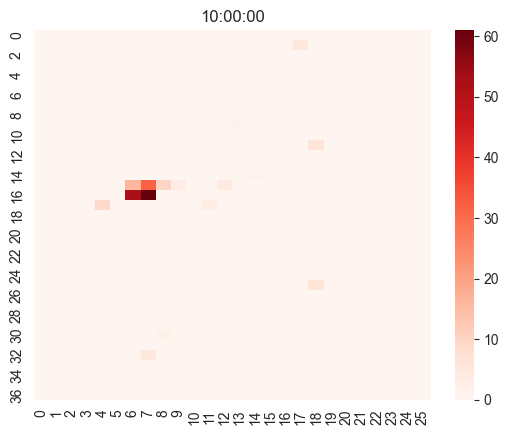

In [8]:
time = model.curr_time
while model.curr_time < time + timedelta(hours=4):
    model.sim()
model.show_failures()

In [10]:
for steps in range(0,32,4):
    model.reset_state(bike_state=original_state,in_transit=[], time=timedelta(hours=6))
    opt_state = state_optimization.optimize(length=timedelta(hours=14), steps=steps)
    avg_failures = 0
    avg_trips = 0
    for i in range(10):
        model.reset_state(bike_state=opt_state,in_transit=[], time=timedelta(hours=6))
        for j in range(14*4):
            model.sim()
        avg_trips += model.total_trips
        avg_failures += model.failures
    print('Steps:', steps, 'Failures:', avg_failures/10, 'Trips:', avg_trips/10, 'Total bikes', sum([model.cluster_dict[i].curr_bikes for i in model.cluster_dict])+len(model.in_transit))

Steps: 0 Failures: 4595.7 Trips: 87623.7 Total bikes 31481
Steps: 4 Failures: 1949.0 Trips: 87984.5 Total bikes 32408
Steps: 8 Failures: 1654.8 Trips: 87934.0 Total bikes 32646
Steps: 12 Failures: 1642.4 Trips: 87858.4 Total bikes 32621
Steps: 16 Failures: 1476.7 Trips: 87889.9 Total bikes 32801
Steps: 20 Failures: 1581.3 Trips: 87791.8 Total bikes 32876


KeyboardInterrupt: 

In [7]:
model.reset_state(bike_state=original_state,in_transit=[], time=timedelta(hours=2))
for tick in range(24*4):
    model.sim()
    print(model.curr_time)
    print(len(model.in_transit), 'in transit')
    print(model.failures, 'failures')
    print(model.critical_failures, 'critical failures')
    print(model.total_trips, 'total trips')
    print('-------------------')
    

2:15:00
85 in transit
2 failures
0 critical failures
0 total trips
-------------------
2:30:00
98 in transit
6 failures
0 critical failures
65 total trips
-------------------
2:45:00
74 in transit
8 failures
0 critical failures
138 total trips
-------------------
3:00:00
81 in transit
13 failures
0 critical failures
202 total trips
-------------------
3:15:00
81 in transit
14 failures
0 critical failures
262 total trips
-------------------
3:30:00
62 in transit
15 failures
0 critical failures
332 total trips
-------------------
3:45:00
62 in transit
16 failures
0 critical failures
379 total trips
-------------------
4:00:00
64 in transit
16 failures
0 critical failures
430 total trips
-------------------
4:15:00
65 in transit
16 failures
0 critical failures
481 total trips
-------------------
4:30:00
69 in transit
16 failures
0 critical failures
533 total trips
-------------------
4:45:00
91 in transit
16 failures
0 critical failures
592 total trips
-------------------
5:00:00
126 in t

<Axes: >

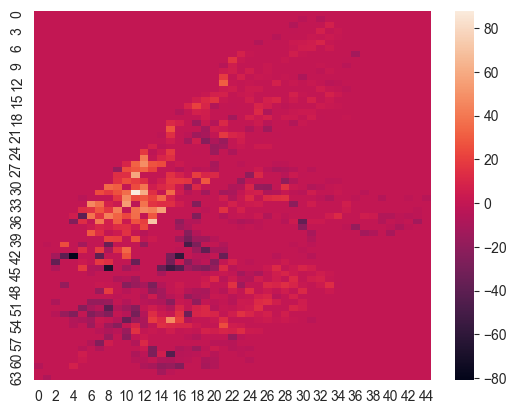

In [16]:
model.reset_state(bike_state=original_state,in_transit=[], time=timedelta(hours=5))
# expected_change = state_optimization.expected_change(num_ticks=8)
opt_state = state_optimization.optimize(length=timedelta(hours=16), steps=8)
change = np.zeros(len(model.clusters))
for i, cluster in zip(opt_state, model.cluster_dict.values()):
    change[cluster.name] = opt_state[i] - original_state[i]
sns.heatmap(change.reshape(model.vertical_squares, model.horizontal_squares))


In [84]:
avg_failures = 0
model.reset_state(bike_state=opt_state,in_transit=[], time=timedelta(hours=6))

for i in range(10):
    for j in range(8):
        model.sim()
    avg_failures += model.failures
    model.reset_state(bike_state=opt_state,in_transit=[], time=timedelta(hours=6))
print(avg_failures/10)

15.1


Bad arrival at  2542 48 48 True
Bad arrival at  2542 48 48 True
Bad arrival at  1323 52 52 True
bad departure 1509 0 27 True
Bad arrival at  1986 27 27 True
Bad arrival at  2004 0 0 True
Bad arrival at  2310 49 49 True
bad departure 2398 0 33 True
bad departure 2398 0 33 True
Bad arrival at  1821 25 25 True
Bad arrival at  1055 29 29 True
Bad arrival at  1986 27 27 True
Bad arrival at  2004 0 0 True
Bad arrival at  1055 29 29 True
Bad arrival at  2395 97 97 True
bad departure 529 0 0 True
bad departure 701 0 27 True
bad departure 1368 0 37 True
bad departure 2398 0 33 True
bad departure 2532 0 25 True
Bad arrival at  1008 36 36 True
Bad arrival at  1008 36 36 True
Bad arrival at  1328 52 52 True
Bad arrival at  1328 52 52 True
Bad arrival at  2315 21 21 True
bad departure 529 0 0 True
bad departure 1368 0 37 True
bad departure 1368 0 37 True
bad departure 1509 0 27 True
bad departure 2398 0 33 True
bad departure 2398 0 33 True
Bad arrival at  2315 21 21 True
Bad arrival at  2712 23 23 

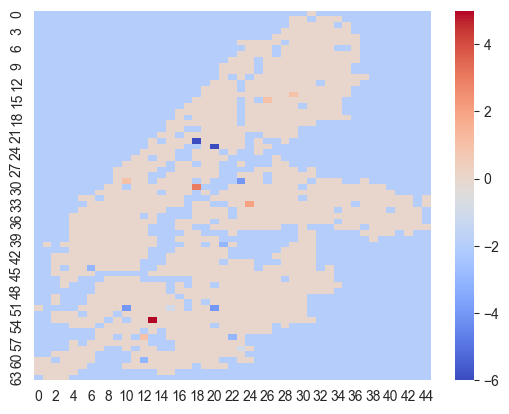

63


In [32]:
opt_state = state_optimization.optimize(1)
print(model.failures)
model.change_time(time=time)
model.load_bikes(opt_state)
model.failures = 0
for cluster in model.cluster_dict.values():
    cluster.bad_arrivals = []
    cluster.bad_departures = []

3:00:00
64 in transit
218 failures
67 critical failures
174 total trips
-------------------
3:15:00
63 in transit
248 failures
71 critical failures
225 total trips
-------------------
3:30:00
67 in transit
275 failures
75 critical failures
275 total trips
-------------------
3:45:00
68 in transit
297 failures
80 critical failures
326 total trips
-------------------
4:00:00
55 in transit
320 failures
81 critical failures
390 total trips
-------------------
4:15:00
52 in transit
343 failures
87 critical failures
436 total trips
-------------------
4:30:00
65 in transit
368 failures
90 critical failures
474 total trips
-------------------
4:45:00
90 in transit
407 failures
97 critical failures
530 total trips
-------------------
5:00:00
93 in transit
445 failures
103 critical failures
609 total trips
-------------------
5:15:00
159 in transit
499 failures
105 critical failures
689 total trips
-------------------
5:30:00
233 in transit
548 failures
111 critical failures
813 total trips
---

0

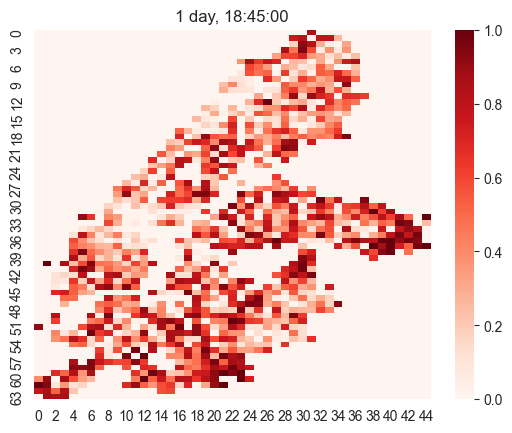

In [5]:
end_time = model.curr_time + timedelta(hours=40)
image_number = 0
while model.curr_time < end_time:
    model.sim()
    # model.sim_by_3()
    print(model.curr_time)
    print(len(model.in_transit), 'in transit')
    print(model.failures, 'failures')
    print(model.critical_failures, 'critical failures')
    print(model.total_trips, 'total trips')
    print('-------------------')
    if image_number < 10:
        t = f'000{image_number}'
    elif image_number < 100:
        t = f'00{image_number}'
    elif image_number < 1000:
        t = f'0{image_number}'
    else:
        t = f'{image_number}'
    # model.show_failures(save=True, name=f'{t}')
    # model.show_bikes(save=True, name=f'{t}')
    model.show_fill_percent(save=True, name=f'{t}')
    image_number += 1
    
# os.system('magick images/failures/*.png gifs/failures_15v2.gif')
# os.system('magick images/bikes/*.png gifs/bikesv2.gif')
os.system('magick images/fill/*.png gifs/fillv2.gif')


In [5]:
model.change_time(time=timedelta(hours=6))
opt_state = state_optimization.optimize(timedelta(hours=16), 8)

Step 1 of 8 completed 9877 failures
Step 2 of 8 completed 7859 failures
Step 3 of 8 completed 6105 failures
Step 4 of 8 completed 6343 failures
Step 5 of 8 completed 5274 failures
Step 6 of 8 completed 5032 failures
Step 7 of 8 completed 4229 failures
Step 8 of 8 completed 4542 failures


In [6]:
dif = [opt_state[i] - original_state[i] if i in opt_state else 0 for i in range(len(model.clusters))]
dif = np.array(dif).reshape(model.vertical_squares, model.horizontal_squares)

In [7]:
max_docks = model.get_max_docks_in_clusters()
mask_specific_color = max_docks != 0
max_docks[max_docks == 0] = 1
percent_diff = dif/max_docks

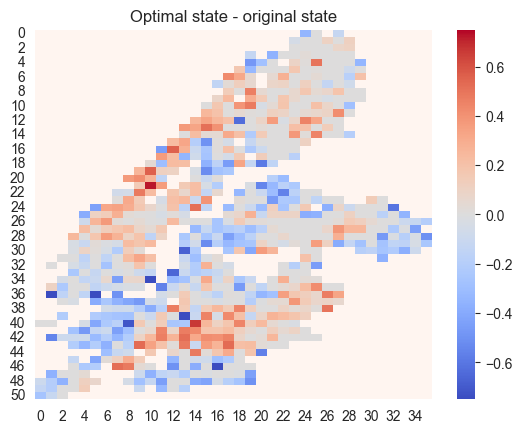

In [8]:
sns.heatmap(percent_diff, cmap='coolwarm', cbar=True, vmin=-0.75, vmax=0.75)
sns.heatmap(percent_diff, mask=mask_specific_color, cmap='Reds', cbar=False)
plt.title('Optimal state - original state')
plt.show()